In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# Find scripts
sys.path.insert(0, "../src/")
from cda_scripts import *

np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset loading and pre-processing (see src/cda_scripts.py)

In [180]:
# Load data
data_path = Path("../", "data")
df_raw_realized = pd.read_excel(Path(data_path,  "Realized_Schedule_20210101-20220228.xlsx"))
df_raw_future = pd.read_excel(Path(data_path, "Future_Schedule_20220301-20220331.xlsx"))

# String conversion
cat_cols = ["FlightNumber", "Destination", "Airline", "Sector", "FlightType", "AircraftType"]
df_raw_realized[cat_cols] = df_raw_realized[cat_cols].astype(str)
df_raw_future[cat_cols] = df_raw_future[cat_cols].astype(str)

In [181]:
# Model for handling data
class DataModel():
    """
    Class for loading, processing and training ML models on Daylio exported CSV file
    """
    def __init__(self, df_train, df_test, verbose=1):
        self.start_time = "2021-01-01"
        self.time_col = "ScheduleTime"

        self.df_train = df_train
        self.df_test = df_test
        
        self.df_proc = None

        self.verbose = verbose

        self.X_train = None
        self.y_train = None

        self.X_valid = None
        self.y_valid = None

    def preprocess(self, cat_cols,
                start_date="2021-05-31",
                year = 0,
                month_list = [0],
                dataset="train"):

        if dataset == "train":
            df_proc = self.df_train.copy()
            print(f"df_train.shape: {df_train.shape}")
            print(df_proc.columns)
        else:
            df_proc = self.df_test.copy()
            print(f"df_test.shape: {df_test.shape}")
            print(df_proc.columns)

        #exclude_time = "2021-02-01"
        #df_proc = filter_exclude_time(df_proc, time_col="ScheduleTime", exclude_time=exclude_time)

        # Add counts for flight and capacity monthly
        df_proc = add_flight_counts(df_proc)

        # Add feature how close to ending date range 0-1 (1 is end date)
        df_proc = add_time_delta(df_proc, start_time=self.start_time, time_col=self.time_col)

        # Create one-hot encoded time features
        df_proc = add_date_features(df_proc, self.time_col)

        # One-hot encode other features
        cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType", "FlightNumber"]

        if dataset == "train":
            df_proc = map_cat_as_numerical(df_proc, cat_cols, target_col="LoadFactor")
        else:
            df_proc = map_cat_as_numerical_test(self.df_train, df_proc, cat_cols, target_col="LoadFactor")

        # Exclude columns
        #exclude_cols = ["Airline", "FlightNumber"]
        #df_proc = remove_columns(df_proc, exclude_cols)

        # Normalize
        #norm_cols = ["SeatCapacity"]
        #df_proc = normalize_minmax_cols(df_proc, norm_cols)

        print(f"Filtering out flights before {start_date}")
        df_proc = filter_time_period(df_proc, start_date)

        print(f"removing months from year {year} and months {month_list}")
        df_proc = filter_exclude_months(df_proc, year, month_list)

        self.df_proc = df_proc
        print(f"df_proc.shape: {df_proc.shape}")
        print(df_proc.columns)

    def get_trainval(self, val_months, val_years):
        """ Return training and validations sets """
        
        X_train, y_train, X_val, y_val = create_trainval(self.df_proc, val_months, val_years)

        return X_train, y_train, X_val, y_val

    def get_test(self):
        """ Return test set """
        X_test = create_test(self.df_proc)

        return X_test


In [182]:
df_train = df_raw_realized.copy()
df_test = df_raw_future.copy()
datamodel = DataModel(df_raw, df_test)

cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
datamodel.preprocess(cat_cols, start_date="2021-01-01")

for year in [2021, 2022]:
    for month in list(range(1, 12+1)):

        if year == 2022 and month >= 3:
            break

        X_train, y_train, X_val, y_val = datamodel.get_trainval([month], [year])
        mean = np.round(y_val.mean(), 3)
        print(f"{year}, {month}, {mean}")

df_train.shape: (39449, 9)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor'],
      dtype='object')
Filtering out flights before 2021-01-01
removing months from year 0 and months [0]
0 0
0
df_proc.shape: (39449, 15)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'FlightCount_week', 't_delta', 't_dayofyear', 't_dayofmonth',
       't_dayofweek', 't_timeofday'],
      dtype='object')
2021, 1, 0.312
2021, 2, 0.388
2021, 3, 0.419
2021, 4, 0.36
2021, 5, 0.464
2021, 6, 0.544
2021, 7, 0.617
2021, 8, 0.543
2021, 9, 0.575
2021, 10, 0.638
2021, 11, 0.585
2021, 12, 0.499
2022, 1, 0.398
2022, 2, 0.582


In [183]:
cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
datamodel.preprocess(cat_cols, start_date="2021-06-01",
                year=2022,
                month_list=[1])

val_months = [11]
val_years = [2021]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_years)
X_train

df_train.shape: (39449, 9)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor'],
      dtype='object')
Filtering out flights before 2021-06-01
removing months from year 2022 and months [1]
2022 1
3493
df_proc.shape: (31324, 15)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'FlightCount_week', 't_delta', 't_dayofyear', 't_dayofmonth',
       't_dayofweek', 't_timeofday'],
      dtype='object')


,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,FlightCount_week,t_delta,t_dayofyear,t_dayofmonth,t_dayofweek,t_timeofday
3802,-0.288637,0.084277,0.154426,-0.083220,-0.247793,0.017179,180,4.0,4.960175,152,1,1,5.416667
3803,0.201203,0.178458,0.163177,0.165627,-0.247793,0.017179,131,3.0,4.962228,152,1,1,6.916667
3804,0.358638,0.176089,0.154426,0.185240,0.247998,0.017179,212,6.0,4.962342,152,1,1,7.000000
3805,0.029052,-0.116025,0.034503,-0.112921,-0.247793,-0.002552,72,4.0,4.963939,152,1,1,8.166667
3806,-0.288637,-0.125579,0.035640,-0.083220,-0.247793,0.017179,180,3.0,4.964738,152,1,1,8.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,0.167526,-0.155540,0.106684,0.111669,-0.247793,0.017179,144,2.0,13.914956,59,28,0,18.750000
39445,0.158585,0.008592,0.097443,0.111669,-0.247793,0.017179,156,1.0,13.915869,59,28,0,19.416667
39446,0.167526,0.142598,0.190955,0.148225,-0.247793,-0.002552,98,1.0,13.916667,59,28,0,20.000000
39447,0.158585,0.191842,0.185986,-0.083220,-0.247793,-0.002552,186,1.0,13.915983,59,28,0,19.500000


### Training Random Forest model on Feb 22 validation month

RF
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.17, MSE: 0.043, Pearson 0.741, Acc: 0.83


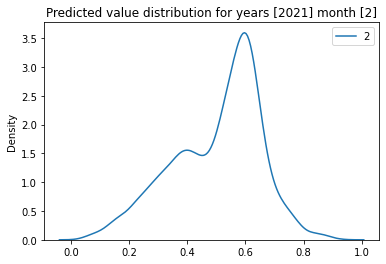

In [184]:
val_months = [2]
val_year = [2022]
X_train, y_train, X_val, y_val = datamodel.get_trainval(val_months, val_year)

# Params
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

print("RF")
f = 0.50
max_features = int(len(X_train.columns) * f)
model = RandomForestRegressor(max_features=max_features, random_state=0)
model, acc_train, acc_val, y_pred_val = fit_model(model, X_train, y_train, X_val, y_val)

sns.kdeplot(y_pred_val)
plt.title(f"Predicted value distribution for years {val_years} month {val_months}")
plt.legend(val_months)

### Random Forest feature importance

/Users/maghoi/opt/anaconda3/envs/py39/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


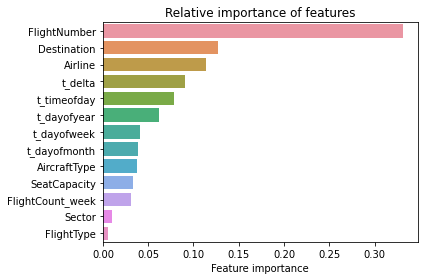

In [185]:
coef = get_coef(model, X_train)

features = ["FlightCount", "MonthCapacity","t_delta", "FlightNumber", "SeatCapacity",
            "t_", "Aircraft_", "Destination_", "Airline_",
            "FlightType_", "Sector_", "SectorCount"]

features = X_train.columns
S = pd.Series(index=features)
for f in features:
    m = coef.index.str.contains(f)
    imp = np.round(coef[m].sort_values()[::-1].sum(), 3)
    S.loc[f] = imp

S_importance = S.sort_values()[::-1]

plt.figure()
sns.barplot(x=S_importance.values, y=S_importance.index)
plt.title("Relative importance of features")
plt.xlabel("Feature importance")

plt.tight_layout()
#plt.savefig("../figures/feature_importance.pdf")


### Leave-one-month-out cross-validation from Jan 21 to Feb 22

In [186]:
# Leave one month out
list_acc_train = []
list_acc_val = []
list_y_pred_val = []
list_y_true_val = []

for year in [2021, 2022]:
    for month in list(range(1, 12+1)):

        if year == 2022 and month >= 3:
            break

        print(f"Year {year}, month {month}")
        X_train, y_train, X_val, y_val = datamodel.get_trainval([month], [year])

        if len(X_val) <= 0:
            continue

        f = 0.50
        max_features = int(len(X_train.columns) * f)
        model = RandomForestRegressor(max_features=max_features, random_state=0)
        model, acc_train, acc_val, y_pred_val = fit_model(model, X_train, y_train, X_val, y_val)

        list_acc_train.append(acc_train)
        list_acc_val.append(acc_val)
        list_y_pred_val.append(y_pred_val)
        list_y_true_val.append(y_val)

Year 2021, month 1
Year 2021, month 2
Year 2021, month 3
Year 2021, month 4
Year 2021, month 5
Year 2021, month 6
Train: MAE: 0.04, MSE: 0.003, Pearson 0.985, Acc: 0.96
Valid: MAE: 0.148, MSE: 0.034, Pearson 0.771, Acc: 0.852
Year 2021, month 7
Train: MAE: 0.04, MSE: 0.003, Pearson 0.984, Acc: 0.96
Valid: MAE: 0.153, MSE: 0.037, Pearson 0.773, Acc: 0.847
Year 2021, month 8
Train: MAE: 0.04, MSE: 0.003, Pearson 0.984, Acc: 0.96
Valid: MAE: 0.128, MSE: 0.028, Pearson 0.78, Acc: 0.872
Year 2021, month 9
Train: MAE: 0.04, MSE: 0.003, Pearson 0.984, Acc: 0.96
Valid: MAE: 0.111, MSE: 0.021, Pearson 0.83, Acc: 0.889
Year 2021, month 10
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.139, MSE: 0.032, Pearson 0.762, Acc: 0.861
Year 2021, month 11
Train: MAE: 0.04, MSE: 0.003, Pearson 0.985, Acc: 0.96
Valid: MAE: 0.129, MSE: 0.026, Pearson 0.784, Acc: 0.871
Year 2021, month 12
Train: MAE: 0.039, MSE: 0.003, Pearson 0.985, Acc: 0.961
Valid: MAE: 0.157, MSE: 0.039, Pearson 0

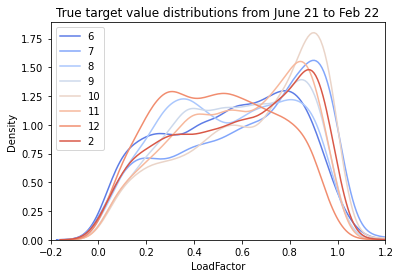

In [206]:
values = list_y_true_val
cmap = sns.color_palette("coolwarm", n_colors=len(values))

for i, preds in enumerate(values):
    sns.kdeplot(preds, color=cmap[i], bw_adjust=1,
                ).set(xlim=(-0.2, 1.2))

labels = [6,7,8,9,10,11,12,2]
plt.legend(labels)
plt.title(f"True target value distributions from June 21 to Feb 22")
plt.savefig("../figures/LOMO_true4.pdf")

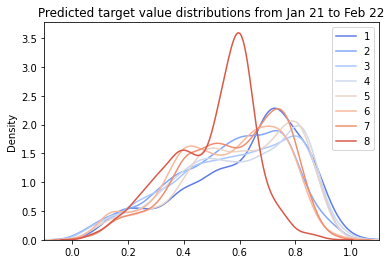

In [188]:
values = list_y_pred_val
cmap = sns.color_palette("coolwarm", n_colors=len(values))

for i, preds in enumerate(values):
    sns.kdeplot(preds, color=cmap[i], bw_adjust=1,
                ).set(xlim=(-0.1, 1.1))

labels = list(range(1, len(values) +1 ))
plt.legend(labels)
plt.title(f"Predicted target value distributions from June 21 to Feb 22")
plt.savefig("../figures/LOMO_pred4.pdf")

### Estimate of mean accuracy and March 2022 expected accuracy

Estimated accuracy for March 2022: 0.848


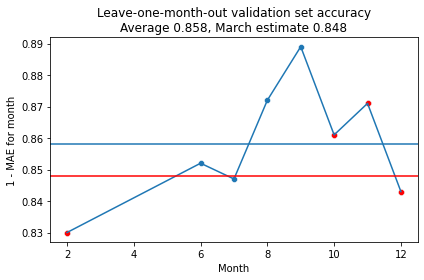

In [208]:
labels = [6,7,8,9,10,11,12,2]
df_plot = pd.DataFrame({
                        "Train_acc": list_acc_train,
                        "Val_acc": list_acc_val,
                        "Month": labels
                        })

ax = sns.lineplot(x=df_plot["Month"], y=df_plot["Val_acc"])
sns.scatterplot(x=df_plot["Month"], y=df_plot["Val_acc"])

plt.ylabel("1 - MAE for month")
plt.xlabel("Month")

mean_acc = df_plot.iloc[:]["Val_acc"].mean().round(3)
estimated_acc = df_plot.iloc[-3:]["Val_acc"].mean().round(3)
print(f"Estimated accuracy for March 2022: {estimated_acc}")

title = "Leave-one-month-out validation set accuracy"
subtitle = f"\nAverage {mean_acc}, March estimate {estimated_acc}"
plt.title(title+subtitle)

plt.axhline(mean_acc)
import matplotlib.dates as mdates

sns.scatterplot(x=df_plot["Month"].iloc[-4:], y=df_plot["Val_acc"].iloc[-4:],
                color="red")
plt.axhline(estimated_acc, color="red")

plt.tight_layout()
plt.savefig("../figures/LOMO4.pdf")

### Predict test set for March 22

In [194]:
# Train again
df_train = df_raw_realized.copy()
df_test = df_raw_future.copy()

datamodel_train = DataModel(df_train, df_test)
cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
datamodel_train.preprocess(cat_cols, month_list=[1], year=2022, dataset="train")

X_train, y_train, X_val, y_val = datamodel_train.get_trainval(val_months=[999], val_years=[999])

print("Retraining model with all training data and testing on all training data")
f = 0.50
max_features = int(len(X_train.columns) * f)
model = RandomForestRegressor(max_features=max_features, random_state=0)
model, acc_train, acc_val, y_pred_val = fit_model(model, X_train, y_train, X_train, y_train)

df_train.shape: (39449, 9)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor'],
      dtype='object')
Filtering out flights before 2021-05-31
removing months from year 2022 and months [1]
2022 1
3493
df_proc.shape: (31379, 15)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'FlightCount_week', 't_delta', 't_dayofyear', 't_dayofmonth',
       't_dayofweek', 't_timeofday'],
      dtype='object')
Retraining model with all training data and testing on all training data
Train: MAE: 0.04, MSE: 0.003, Pearson 0.985, Acc: 0.96
Valid: MAE: 0.04, MSE: 0.003, Pearson 0.985, Acc: 0.96


In [195]:
datamodel_test = DataModel(df_train, df_test)
cat_cols = ["Destination", "Airline", "Sector", "FlightType", "AircraftType"]
datamodel_test.preprocess(cat_cols, dataset="test")

X_test = datamodel_test.get_test()

df_test.shape: (4813, 8)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity'],
      dtype='object')
Filtering out flights before 2021-05-31
removing months from year 0 and months [0]
0 0
0
df_proc.shape: (4813, 14)
Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity',
       'FlightCount_week', 't_delta', 't_dayofyear', 't_dayofmonth',
       't_dayofweek', 't_timeofday'],
      dtype='object')


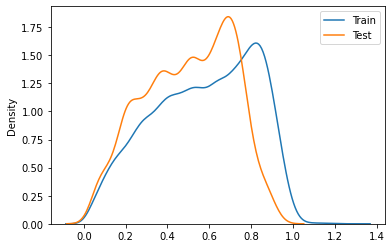

In [196]:
# Handle missing values by fitting with mean rank-value from X_train
means = X_train.mean()
y_hat_test = model.predict(X_test.fillna(means).values)

# Compare with validation
y_hat_train = model.predict(X_train.values)

# Plot distribution
sns.kdeplot(y_hat_train)
sns.kdeplot(y_hat_test)
plt.legend(["Train", "Test"])

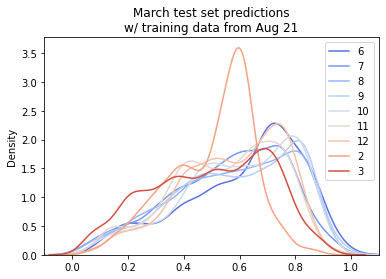

In [210]:
values = list_y_pred_val
cmap = sns.color_palette("coolwarm", n_colors=len(values)+2)

for i, preds in enumerate(values):
    sns.kdeplot(preds, color=cmap[i], bw_adjust=1,
                ).set(xlim=(-0.1, 1.1))

sns.kdeplot(y_hat_test, color=cmap[-1], bw_adjust=1,
            ).set(xlim=(-0.1, 1.1))

labels = [6,7,8,9,10,11,12,2,3]
plt.legend(labels)
plt.title("March test set predictions\nw/ training data from Aug 21")
plt.savefig("../figures/LOMO_with_march4.pdf")

In [198]:
df_proc_future = df_raw_future.copy()
df_proc_future["LoadFactor"] = y_hat_test

In [199]:
df_proc_future.to_excel("../march_predictions4.xlsx")